In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import pandas as pd

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
from tqdm import tqdm
tqdm.pandas()

/home/alexander/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
RS = 7345

# Загрузка данных

In [5]:
# DATA_DIR = pathlib.Path("../data/names/uploads")

In [6]:
# train = pd.read_csv(DATA_DIR.joinpath("train.csv"), index_col="pair_id")
# test = pd.read_csv(DATA_DIR.joinpath("test.csv"), index_col="pair_id")

In [7]:
train = pd.read_csv("train.csv", index_col="pair_id")
test = pd.read_csv("test.csv", index_col="pair_id")

In [8]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


In [9]:
test.head()

,name_1,name_2
pair_id,,
1,Sun Blinds Decoration Inc.,Indl De Cuautitlan Sa Cv
2,Eih Ltd.,"Dongguan Wei Shi Plastic Product Co., Ltd."
3,Jsh Ltd. (Hk),Arab Shipbuilding And Repair Yard C
4,Better Industrial Ltd.,Farmacap Industria E Comercio Ltda
5,Equipos Inoxidables Del Norte Sa De Cv,Bel Inc.


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213249 entries, 1 to 213249
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name_1  213249 non-null  object
 1   name_2  213249 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


# Статистика таргета

In [12]:
train.is_duplicate.value_counts()

0    494161
1      3658
Name: is_duplicate, dtype: int64

In [13]:
train[train.is_duplicate==1].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
326383,Basf India,Basf India Ltd.,1
447193,"Bridgestone India Pvt., Ltd.",Bridgestone Do Brasil Industria E Comenrcio Ltda,1
66992,Shenyang Bridgestone,Warren Plant Bato Bridgestone,1
33003,"Saint Gobain India Pvt., Ltd.",Saint Gobain Canada Inc.,1
438074,Hansa Flex Usa,K Flex Usa,1
376077,Bridgestone Hosepower Llc,Bridgestone Firestone Venezolana C,1
277151,Bridgestone Hosepower Llc,Bridgestone Stargard Sp Zoo,1
464881,Sika Sa,Sika S.A. Chile,1
452624,Sika Corporation,Sika India Private Ltd.,1


In [14]:
train[train.is_duplicate==0].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
395593,Bridgestone Do Brasil Industria E Comenrcio Ltda,Industria Mecanica Vogt S.A.,0
483493,Alxrma Trading Co.,Zlt Trading Inc.,0
487378,Iviltra Uab,MOL,0
178694,"Shanghai Chengjun Xiangsu Co., Ltd.","Miao Shanghai Heng Trading Co., Ltd.",0
459875,Evonik Corporation C/O Stockhausen,Usa.,0
447619,Eskay Enterprises,Global Polyrub Enterprise,0
34327,CROSSPOLIMERI S.P.A.,Nizhnekamsk,0
103737,"Yao Yuan Shanghai International Trade Co., Ltd.","Shanghai Oasis International Trading Co., Ltd.",0
45498,Guangdong Chemical & Light Industrial Coporation,Industrial Roller Corporation,0


# Очистка данных

In [15]:
pip install pycountry

Note: you may need to restart the kernel to use updated packages.


In [16]:
import pycountry
import re

In [17]:
countries = [country.name.lower() for country in pycountry.countries]

In [19]:
train["name_1"] = train["name_1"].str.lower()
train["name_2"] = train["name_2"].str.lower()

test["name_1"] = test["name_1"].str.lower()
test["name_2"] = test["name_2"].str.lower()

In [65]:
train[train.name_1.str.contains("gmbh")]

,name_1,name_2,is_duplicate,levenstein,norm_levenstein
pair_id,,,,,
824,impexa aussenhandelsgmbh,desi,0,21.0,0.875000
8378,impexa aussenhandelsgmbh,lauren s a,0,19.0,0.791667
24278,fr meyers sohn gmbhkg,reytek s a de c v,0,15.0,0.714286
29992,ter hell gmbh,werner janikowo sp z o o,0,20.0,0.833333
101129,ter hell gmbh,ter group,1,9.0,0.692308
108168,ter hell gmbh,полимаркет ооо,0,15.0,1.000000
114888,fr meyers sohn gmbhkg,ram,0,19.0,0.904762
115021,impexa aussenhandelsgmbh,jus international,0,21.0,0.875000
136834,ter hell gmbh,warden asphalt,0,12.0,0.857143


In [21]:
legal_entities = ["ltd.", "co.", "inc.", "b.v.", "s.c.r.l.", "gmbh", "pvt."]

for entity in tqdm(legal_entities):
    train.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)
    test.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)

100%|██████████| 7/7 [00:17<00:00,  2.57s/it]


In [66]:
train[train.name_1.str.contains("gmbh")]

,name_1,name_2,is_duplicate,levenstein,norm_levenstein
pair_id,,,,,
824,impexa aussenhandelsgmbh,desi,0,21.0,0.875000
8378,impexa aussenhandelsgmbh,lauren s a,0,19.0,0.791667
24278,fr meyers sohn gmbhkg,reytek s a de c v,0,15.0,0.714286
29992,ter hell gmbh,werner janikowo sp z o o,0,20.0,0.833333
101129,ter hell gmbh,ter group,1,9.0,0.692308
108168,ter hell gmbh,полимаркет ооо,0,15.0,1.000000
114888,fr meyers sohn gmbhkg,ram,0,19.0,0.904762
115021,impexa aussenhandelsgmbh,jus international,0,21.0,0.875000
136834,ter hell gmbh,warden asphalt,0,12.0,0.857143


In [22]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,iko industries,"enormous industrial trade,",0
2,apcotex industries,technocraft industries (india),0
3,"rishichem distributors,",dsa,0
4,powermax rubber factory,co. one,0
5,tress a/s,longyou industries park zhejiang,0


In [23]:
test.head()

,name_1,name_2
pair_id,,
1,sun blinds decoration,indl de cuautitlan sa cv
2,eih,"dongguan wei shi plastic product,"
3,jsh(hk),arab shipbuilding and repair yard c
4,better industrial,farmacap industria eercio
5,equipos inoxidables del norte sa de cv,bel


In [24]:
train.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
test.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

In [25]:
for country in tqdm(countries):
    train.replace(re.compile(country), "", inplace=True)
    test.replace(re.compile(country), "", inplace=True)

100%|██████████| 249/249 [07:40<00:00,  1.85s/it]


In [26]:
train.replace(re.compile(r"[^\w\s]"), "", inplace=True)
test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

In [27]:
train.sample(25)

,name_1,name_2,is_duplicate
pair_id,,,
170921,elite carbon fabrics llc,toray carbon fibers europe sa,0
449058,general sealants,devan sealants,0
295655,albemarleporation,termoprene polymers,0
46615,berg international ind llc,cody synthetic rubber jiangsu,0
344380,arnott,manhattan rubber plastic mfgp,0
336959,ding xin internation trading,taporation,0
30178,protex sa,wei transportes eireli me,0
431624,trident investments,viat instruments,0
35845,synthetic packers,wa international,0


In [28]:
test.sample(25)

,name_1,name_2
pair_id,,
183589,conic,sunway electronics
8694,sertrading br,national material trading llc
165526,safety glass works,elast won
100187,panasonic energyp of america,panova
1055,gaucho industriaercio importacao e exportacao d,carpio imp
210960,jinshan associateod tradingp,cosmos trading
169676,pt indorama synthentics tbk,lynden international
72319,gp,sports merchandising irland
14543,finchem,maersk trade finance a s


# Простые метрики сходства строк

In [30]:
pip install strsimpy

     |████████████████████████████████| 45 kB 740 kB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [31]:
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

In [32]:
levenshtein = Levenshtein()

train["levenstein"] = train.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)
test["levenstein"] = test.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 213249/213249 [00:41<00:00, 5188.97it/s]


In [33]:
train.head()

,name_1,name_2,is_duplicate,levenstein
pair_id,,,,
1,iko industries,enormous industrial trade,0,15.0
2,apcotex industries,technocraft industries,0,9.0
3,rishichem distributors,dsa,0,20.0
4,powermax rubber factory,co one,0,20.0
5,tress as,longyou industries park zhejiang,0,26.0


In [38]:
train[train['is_duplicate']==1]['levenstein'].mean()

12.877255330781848

In [39]:
train[train['is_duplicate']==0]['levenstein'].mean()

18.61953492889969

In [40]:
normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenstein"] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                                axis=1)
test["norm_levenstein"] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                              axis=1)

100%|██████████| 213249/213249 [00:41<00:00, 5099.91it/s]


In [41]:
train.head()

,name_1,name_2,is_duplicate,levenstein,norm_levenstein
pair_id,,,,,
1,iko industries,enormous industrial trade,0,15.0,0.600000
2,apcotex industries,technocraft industries,0,9.0,0.409091
3,rishichem distributors,dsa,0,20.0,0.909091
4,powermax rubber factory,co one,0,20.0,0.869565
5,tress as,longyou industries park zhejiang,0,26.0,0.812500


In [42]:
print (train[train['is_duplicate']==1]['norm_levenstein'].mean())
print ()
print (train[train['is_duplicate']==0]['norm_levenstein'].mean())

0.5000877974876978

0.7240309842806352


/home/alexander/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


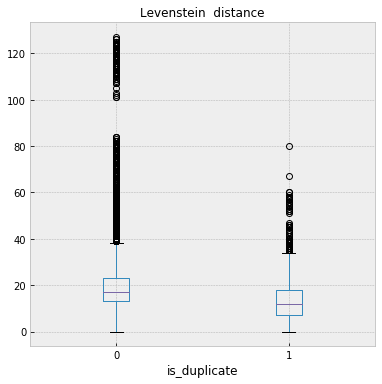

In [43]:
plt.figure(figsize=(6,6))

train.boxplot("levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Levenstein  distance", fontsize=12);

/home/alexander/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


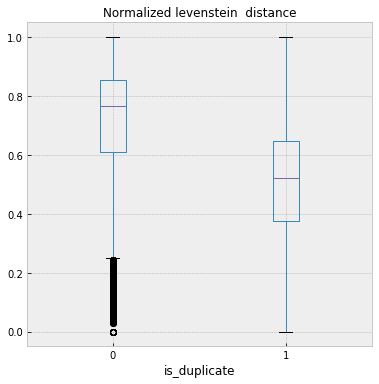

In [44]:
plt.figure(figsize=(6,6))

train.boxplot("norm_levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Normalized levenstein  distance", fontsize=12);

# Базовая модель

In [45]:
FTS = ["levenstein", "norm_levenstein"]
THR = 0.9

In [46]:
split = StratifiedShuffleSplit(1, train_size=0.8, random_state=RS)
tridx, cvidx = list(split.split(train[FTS], train["is_duplicate"]))[0]

In [63]:
train.shape

(497819, 5)

In [62]:
cvidx.shape[0] + tridx.shape[0]

497819

In [59]:
tridx.shape

(398255,)

In [60]:
cvidx.shape

(99564,)

In [64]:
tridx

array([264143, 138288, 367291, ..., 331763, 321495, 285865])

In [54]:
train.iloc[tridx][FTS].values

array([[15.        ,  0.57692308],
       [ 6.        ,  0.20689655],
       [10.        ,  0.38461538],
       ...,
       [ 6.        ,  0.85714286],
       [ 9.        ,  0.42857143],
       [15.        ,  0.9375    ]])

In [47]:
model = LogisticRegression(class_weight="balanced")
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

In [49]:
tr_preds = (tr_preds[:, 1] > THR).astype(np.int)
cv_preds = (cv_preds[:, 1] > THR).astype(np.int)

In [50]:
print(classification_report(train.iloc[tridx]["is_duplicate"].values, tr_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    395329
           1       0.17      0.13      0.15      2926

    accuracy                           0.99    398255
   macro avg       0.58      0.56      0.57    398255
weighted avg       0.99      0.99      0.99    398255



In [51]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     98832
           1       0.17      0.14      0.15       732

    accuracy                           0.99     99564
   macro avg       0.58      0.57      0.57     99564
weighted avg       0.99      0.99      0.99     99564



In [52]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.14792338327327895
0.15128593040847202


# Генерация сабмита

In [ ]:
sample_sub = pd.read_csv(DATA_DIR.joinpath("sample_submission.csv"), index_col="pair_id")

In [ ]:
sample_sub

In [ ]:
sample_sub["is_duplicate"] = (model.predict_proba(test[FTS].values)[:, 1] > THR).astype(np.int)

In [ ]:
sample_sub.is_duplicate.value_counts()

In [ ]:
sample_sub.to_csv(DATA_DIR.joinpath("baseline_submission.csv"))